In [1]:
import warnings
warnings.filterwarnings("ignore")


pip install patchify

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import glob
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as trns
import torch.nn as nn
# from torchmetrics import JaccardIndex
from sklearn.model_selection import train_test_split
from PIL import ImageColor
import matplotlib.patches as mpatches
import torchvision
import cv2
from patchify import patchify
from PIL import Image
from keras.utils import to_categorical
# import segmentation_models as sm

In [3]:
class CustomData(Dataset):
    def __init__(self, train=True):
        BGR_classes = {'Water' :[226, 169, 41],
                            'Land' : [132, 41, 246],
                            'Road' : [110, 193, 228],
                            'Building' : [60, 16, 152],
                            'Vegetation' : [254, 221, 58],
                            'Unlabeled' : [155, 155, 155]} 
        self.patch_size = 256
        self.images = []
        self.masks = []
        folders = glob.glob("../data/*")
       
        for f in folders:
            files = glob.glob(f"{f}/*")
            
            self.images.append(glob.glob(f"{files[0]}/*")); self.masks.append(glob.glob(f"{files[1]}/*"))
        self.images= sorted(np.array(self.images).reshape(-1)); self.masks = sorted(np.array(self.masks).reshape(-1))
        X_train, X_test, y_train, y_test = train_test_split(self.images, self.masks, test_size=0.2, shuffle=True)
        self.np_images = []
        self.np_masks = []


        trans = trns.Compose([trns.ToTensor()])
        if train:
            for li, lm in zip(X_train, y_train):
                image = cv2.imread(li, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//self.patch_size)*self.patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//self.patch_size)*self.patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", li)
                patches_img = patchify(image, (self.patch_size, self.patch_size, 3), step=self.patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        single_patch_img = trans(single_patch_img[0])
                                  
                        self.np_images.append(single_patch_img)
                        
                mask = cv2.imread(lm)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//self.patch_size)*self.patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//self.patch_size)*self.patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", lm)
                patches_mask = patchify(mask, (self.patch_size, self.patch_size, 3), step=self.patch_size)
           
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        label_seg = np.zeros(single_patch_mask[0].shape, dtype=np.uint8)
                        label_seg[np.all(single_patch_mask[0]==BGR_classes['Building'], axis=-1)]=0
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Land"], axis=-1)]=1
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Road"], axis=-1)]=2
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Vegetation"], axis=-1)]=3
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Water"], axis=-1)]=4
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Unlabeled"], axis=-1)]=5
                        label_seg = to_categorical(label_seg[:,:,0], num_classes=6)
                        single_patch_mask = trans(label_seg)

                        self.np_masks.append(single_patch_mask) 
                    
                
            
                
        else:
            for li, lm in zip(X_test, y_test):
                image = cv2.imread(li, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//self.patch_size)*self.patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//self.patch_size)*self.patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", li)
                patches_img = patchify(image, (self.patch_size, self.patch_size, 3), step=self.patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        
                        
                        single_patch_img = trans(single_patch_img[0])#Use minmaxscaler instead of just dividing by 255.
                        
                        self.np_images.append(single_patch_img)
                        
                mask = cv2.imread(lm)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//self.patch_size)*self.patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//self.patch_size)*self.patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", lm)
                patches_mask = patchify(mask, (self.patch_size, self.patch_size, 3), step=self.patch_size)

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        label_seg = np.zeros(single_patch_mask[0].shape, dtype=np.uint8)
                        label_seg[np.all(single_patch_mask[0]==BGR_classes['Building'], axis=-1)]=0
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Land"], axis=-1)]=1
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Road"], axis=-1)]=2
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Vegetation"], axis=-1)]=3
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Water"], axis=-1)]=4
                        label_seg[np.all(single_patch_mask[0]==BGR_classes["Unlabeled"], axis=-1)]=5
                        label_seg = to_categorical(label_seg[:,:,0], num_classes=6)
                        single_patch_mask = trans(label_seg)
                                                    
                        self.np_masks.append(single_patch_mask)      
        
    def __getitem__(self, index) :
        return self.np_images[index], self.np_masks[index]
    def __len__(self):
        return len(self.np_images)

In [4]:
Train_data = CustomData()
Test_data = CustomData(False)

Now patchifying image: ../data\Tile 8\images\image_part_009.jpg
Now patchifying mask: ../data\Tile 8\masks\image_part_009.png
Now patchifying image: ../data\Tile 6\images\image_part_008.jpg
Now patchifying mask: ../data\Tile 6\masks\image_part_008.png
Now patchifying image: ../data\Tile 1\images\image_part_004.jpg
Now patchifying mask: ../data\Tile 1\masks\image_part_004.png
Now patchifying image: ../data\Tile 3\images\image_part_005.jpg
Now patchifying mask: ../data\Tile 3\masks\image_part_005.png
Now patchifying image: ../data\Tile 3\images\image_part_006.jpg
Now patchifying mask: ../data\Tile 3\masks\image_part_006.png
Now patchifying image: ../data\Tile 8\images\image_part_008.jpg
Now patchifying mask: ../data\Tile 8\masks\image_part_008.png
Now patchifying image: ../data\Tile 3\images\image_part_001.jpg
Now patchifying mask: ../data\Tile 3\masks\image_part_001.png
Now patchifying image: ../data\Tile 3\images\image_part_003.jpg
Now patchifying mask: ../data\Tile 3\masks\image_part_

In [5]:
len(Train_data.np_images)

1088

In [6]:
len(Test_data.np_masks)

357

In [7]:
train_loader = DataLoader(Train_data, 16, True)
test_loader= DataLoader(Test_data, 8, shuffle=True)

In [8]:
x= next(iter(train_loader))

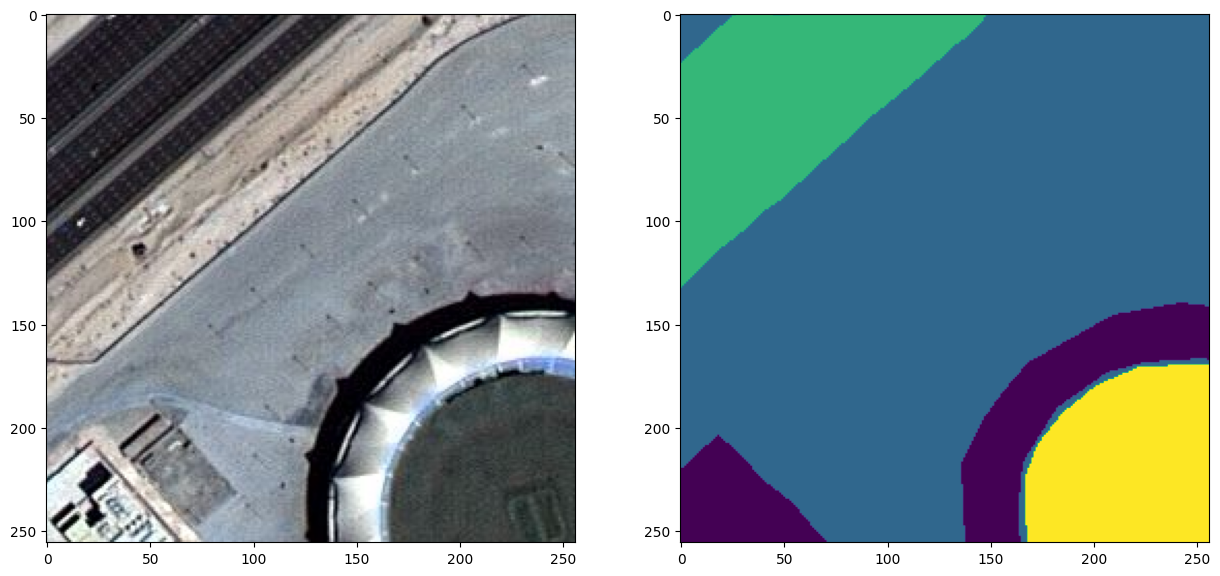

In [12]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(x[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(np.argmax(x[1][0].permute(1,2,0).numpy(), axis=2))

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=6, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = UNet()

In [11]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceloss, self).init()
    def forward(self,pred, target):
       smooth = 1e-6
       iflat = pred.contiguous().view(-1)
       torchlat = target.contiguous().view(-1)
       intersection = (iflat * torchlat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(torchlat * torchlat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0008),
])

criterion = diceloss()

In [12]:
def Train_model(
        model,
        data_loader,
        criterion,
        optim,
        metrix,
):
    losses= []
    iou = []
    localization_error=[]
    Jaccard = []
    model.train()
    for img , msk in data_loader:
        img, msk = img.to(DEVICE), msk.to(DEVICE)

        logits = model(img)
        loss = criterion(msk, logits)
        result = metrix.calculate(
            np.argmax(msk.squeeze().cpu().permute(2,3,1,0).numpy(), axis=2),
            np.argmax(logits.squeeze().detach().cpu().permute(2,3,1,0).numpy(),axis=2),
            strict=True,
            iou_threshold=0.7
        ) 
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.detach().cpu()); iou.append(result.results.IoU);localization_error.append(result.results.localization_error);Jaccard.append(result.results.Jaccard)
    print(f"Train Loss: {np.array(losses).mean() :.4f} | Train IoU: {np.array(iou).mean() :4f} | Train Jaccard: {np.array(Jaccard).mean():4f} | Trian Localization Error: {np.array(localization_error).mean():4f}")
    return np.array(losses).mean(), np.array(iou).mean(), np.array(Jaccard).mean(), np.array(localization_error).mean()

def Test_model(
        model,
        data_loader,
        criterion,
        metrix,):
    losses= []
    iou = []
    localization_error=[]
    Jaccard = []
    model.eval()
    with torch.inference_mode():
        for img, msk in data_loader:
            img, msk = img.to(DEVICE), msk.to(DEVICE)
            logits = model(img)
            loss = criterion(logits, msk)
            result = metrix.calculate(
            np.argmax(msk.squeeze().cpu().permute(2,3,1,0).numpy(), axis=2),
            np.argmax(logits.squeeze().detach().cpu().permute(2,3,1,0).numpy(),axis=2),
            strict=True,
            iou_threshold=0.7
        ) 
            losses.append(loss.detach().cpu()); iou.append(result.results.IoU);localization_error.append(result.results.localization_error);Jaccard.append(result.results.Jaccard)
    print(f"Test Loss: {np.array(losses).mean() :.4f} | Test IoU: {np.array(iou).mean() :4f} | Test Jaccard: {np.array(Jaccard).mean():4f} | Test Localization Error: {np.array(localization_error).mean():4f}")
    return np.array(losses).mean(), np.array(iou).mean(), np.array(Jaccard).mean(), np.array(localization_error).mean()


In [13]:
losses = []
ious = []
localization_errors=[]
Jaccards = []
tlosses=[]
tiou = []
tlocalization_error=[]
tJaccard= []

pip install umetrix

In [14]:
import umetrix

In [15]:
DEVICE


device(type='cuda')

In [16]:
from tqdm import tqdm

In [ ]:
model.to(DEVICE)
for i in tqdm(range(50, 101)):
    print(f"{'#'*20} Epoch {i} {'#'*20}")
    print("Training....")
    l, iou, jaccard, le= Train_model(model, train_loader, criterion, optimizer, umetrix)
    losses.append(l); ious.append(iou); Jaccards.append(jaccard); localization_errors.append(le)
    print("Testing.......")
    lt, iout, jaccardt, let = Test_model(model, test_loader, criterion, umetrix)
    tlosses.append(lt); tiou.append(iout); tJaccard.append(jaccardt); tlocalization_error.append(let) 


In [ ]:
# for first 50 epoch time is "1:19:49"
# for second 51 epoch time is "1:17:29"

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(losses, label="train")
plt.plot(tlosses, label="test")
plt.legend()

In [ ]:
d = iter(test_loader)

In [ ]:
model.eval()
x = next(d)
with torch.no_grad():
    pred = model(x[0][0].unsqueeze(0).to(DEVICE))

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(x[0][0].squeeze().permute(1,2,0))
plt.subplot(2,3,2)
plt.imshow(np.argmax(x[1][0].permute(1,2,0).numpy(),axis=2).squeeze())
plt.subplot(2,3,3)
plt.imshow(np.argmax(pred.squeeze().cpu().permute(1,2,0),axis=2))
with torch.no_grad():
    pred = model(x[0][1].unsqueeze(0).to(DEVICE))
plt.subplot(2,3,4)
plt.imshow(x[0][1].squeeze().permute(1,2,0))
plt.subplot(2,3,5)
plt.imshow(np.argmax(x[1][1].permute(1,2,0).numpy(),axis=2).squeeze())
plt.subplot(2,3,6)
plt.imshow(np.argmax(pred.squeeze().cpu().permute(1,2,0),axis=2))

In [ ]:
torch.save(model, "./model_101_epoch_patchifyImages_0.0633.pth")
torch.save(model.state_dict(), "./model_state_dict_101_epoch_patchifyImages_0.0633.pth")


In [ ]:
import os

In [ ]:
os.mkdir("metrics")

In [ ]:
np.save("./metrics/model_20_epoch_patchifyImages_0.0311_losses", np.array(losses))
np.save("./metrics/model_20_epoch_patchifyImages_0.0311_ious", np.array(ious))
np.save("./metrics/model_20_epoch_patchifyImages_0.0311_localiztion_errors",np.array(localization_errors))
np.save("./metrics/model_20_epoch_patchifyImages_0.0311_Jaccards",np.array(Jaccards))
np.save("./metrics/model_20_epoch_patchifyImages_0.0311_TestLosses",np.array(tlosses))
np.save("./metrics/model_20_epoch_patchifyImages_0.0311_TestIoUs",np.array(tiou))
np.save("./metrics/model_20_epoch_patchifyImages_0.0311_TestLocalizationErrors",np.array(tlocalization_error))
np.save("./metrics/model_20_epoch_patchifyImages_0.0311_TestJaccards",np.array(tJaccard))

In [ ]:
with torch.no_grad():
    pred = model(x[0].to(DEVICE))

In [ ]:
x[1].shape

In [ ]:
result = umetrix.calculate(
    np.argmax(x[1].squeeze().permute(2,3,1,0).numpy(),axis=2),
    np.argmax(pred.squeeze().cpu().permute(2,3,1,0).numpy(),axis=2),
    strict=True,
    iou_threshold=0.7
)

In [ ]:
result.results

In [ ]:
result.results.localization_error

In [19]:
import torchsummary

In [20]:
x[0].shape

torch.Size([16, 3, 256, 256])

In [13]:
model = torch.load("../models and metrics/final model and metrics/model_101_epoch_patchifyImages_0.0633.pth")

In [44]:
torchsummary.summary(model, (3, 256, 256))

NameError: name 'torchsummary' is not defined

(440, 1280, 3)
1280
256
(256, 1280, 3)


(1, 5, 1, 256, 256, 3)

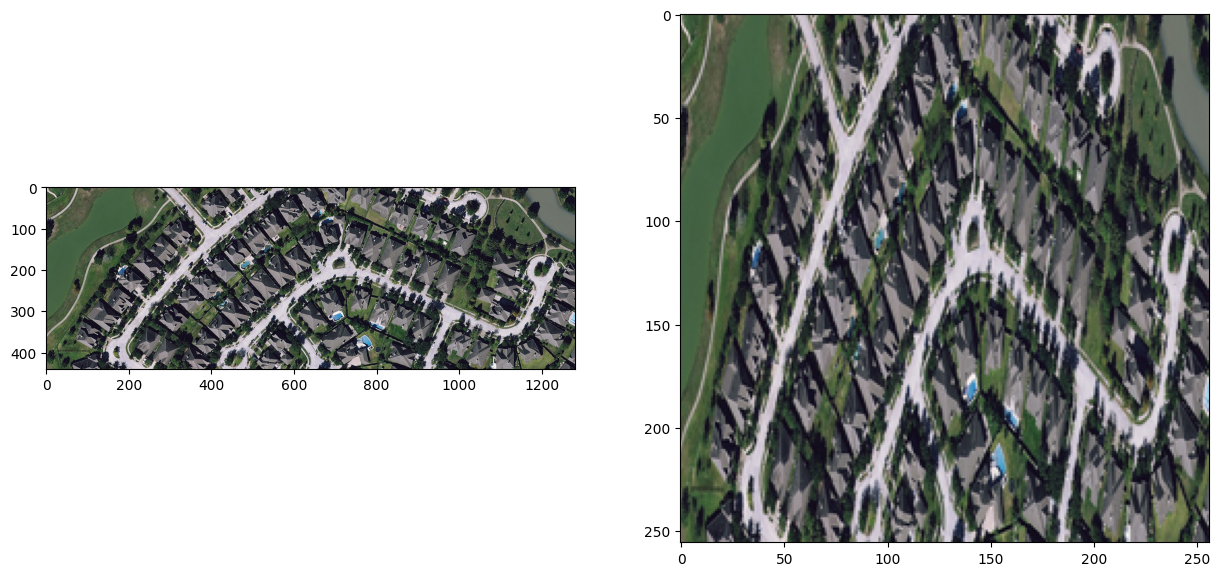

In [14]:
image = cv2.imread("../test/3.jpg", 1)  #Read each image as BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image)
img = Image.fromarray(image)
plt.subplot(1,2,2)
img = img.resize((256, 256))
plt.imshow(img)
SIZE_X = (image.shape[1]//256)*256 #Nearest size divisible by our patch size
print(SIZE_X)
SIZE_Y = (image.shape[0]//256)*256 #Nearest size divisible by our patch size
print(SIZE_Y)
image = Image.fromarray(image)
# print(image.show())
image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
#image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
image = np.array(image)    
print(image.shape)
patches_img = patchify(image, (256, 256, 3), step=256)
patches_img.shape


In [46]:
440//256

1

In [47]:
patches_img.shape

(1, 5, 1, 256, 256, 3)

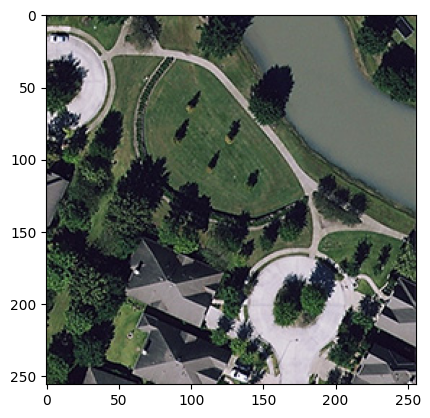

In [48]:
plt.imshow(patches_img[0,-1,:,:][0])

In [49]:
trans = trns.Compose([trns.ToTensor()])

In [50]:
images=[]

In [51]:
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:]
        
        single_patch_img = trans(single_patch_img[0])
                    
        images.append(single_patch_img)

In [52]:
# images= np.array(images)

In [53]:
images[-1].shape

torch.Size([3, 256, 256])

In [54]:
r_image = Image.fromarray(image).resize((256,256))

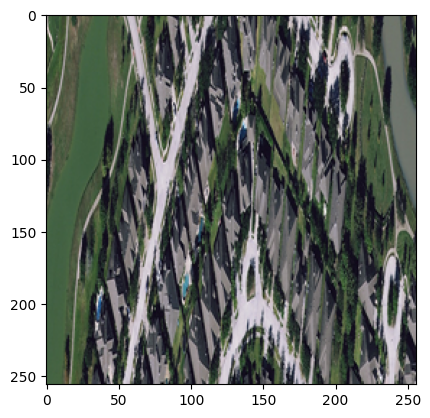

In [55]:
plt.imshow(r_image)

In [56]:
rt_image= trans(r_image)
rt_image.shape

torch.Size([3, 256, 256])

In [57]:
model.to(DEVICE)

UNet(
  (down_conv1): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv2): DownBlock(
    (double_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

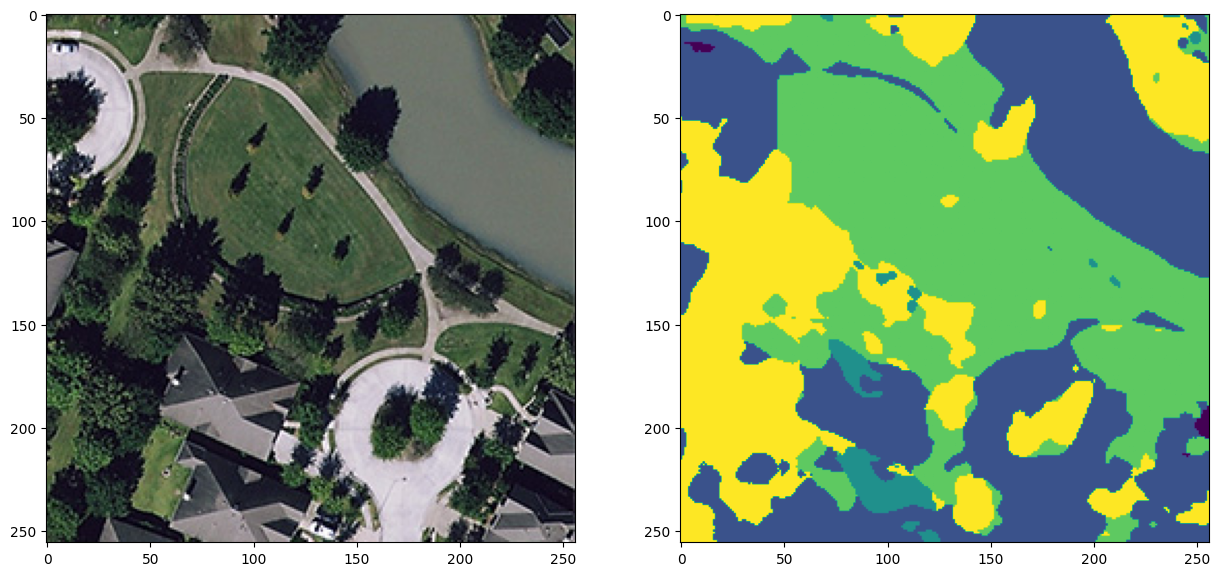

In [66]:
i=-1

with torch.inference_mode():
    pred= model(images[i].unsqueeze(0).to(DEVICE))

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(images[i].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(torch.argmax(pred, dim=1).squeeze().cpu())

In [75]:
torch.argmax(pred, dim=1)[0][0]

tensor([3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
        4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2,
        2, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [68]:
def conv_to_RGB(pred):
    n_pred = torch.argmax(pred, dim=1).squeeze().cpu()
    BGR_classes = {'Water' :[226, 169, 41],
                            'Land' : [132, 41, 246],
                            'Road' : [110, 193, 228],
                            'Building' : [60, 16, 152],
                            'Vegetation' : [254, 221, 58],
                            'Unlabeled' : [155, 155, 155]} 
    single_patch_mask = n_pred
    label_seg = np.zeros((single_patch_mask.shape[0],single_patch_mask.shape[1],3), dtype=np.uint8)
    label_seg[single_patch_mask==0]=BGR_classes['Building']
    label_seg[single_patch_mask==1]=BGR_classes["Land"]
    label_seg[single_patch_mask==2]=BGR_classes["Road"]
    label_seg[single_patch_mask==3]=BGR_classes["Vegetation"]
    label_seg[single_patch_mask==4]=BGR_classes["Water"]
    label_seg[single_patch_mask==5]=BGR_classes["Unlabeled"]
    return label_seg

In [69]:
def conv_to_RGB_lbl(lbl):
    n_pred = torch.argmax(lbl,dim=0)
    BGR_classes = {'Water' :[226, 169, 41],
                            'Land' : [132, 41, 246],
                            'Road' : [110, 193, 228],
                            'Building' : [60, 16, 152],
                            'Vegetation' : [254, 221, 58],
                            'Unlabeled' : [155, 155, 155]} 
    single_patch_mask = n_pred
    label_seg = np.zeros((single_patch_mask.shape[0],single_patch_mask.shape[1],3), dtype=np.uint8)
    label_seg[single_patch_mask==0]=BGR_classes['Building']
    label_seg[single_patch_mask==1]=BGR_classes["Land"]
    label_seg[single_patch_mask==2]=BGR_classes["Road"]
    label_seg[single_patch_mask==3]=BGR_classes["Vegetation"]
    label_seg[single_patch_mask==4]=BGR_classes["Water"]
    label_seg[single_patch_mask==5]=BGR_classes["Unlabeled"]
    return label_seg

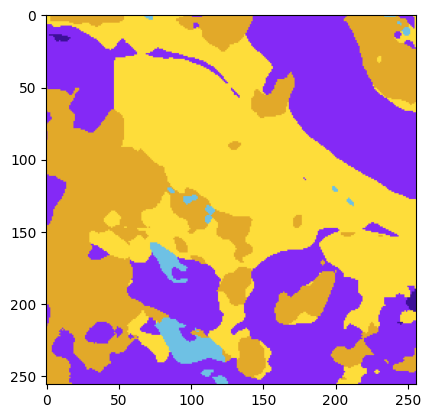

In [70]:
plt.imshow(conv_to_RGB(pred))

In [77]:
pred.shape

torch.Size([1, 6, 256, 256])

In [76]:
conv_to_RGB(pred).shape

(256, 256, 3)